# Genomic data Processing using Python 🐍🧬
                 made by: Szymon Jakubowski 

In order to obtain informations from raw Next-Gen Sequencing data in fastq format (which is the nucleotide read and quality of this read), we need to:
1. Explore qualities of the reads and their lengths 
2. Preprocess the data based on their quality
3. Perform pipeline operations using tools from Docker image 
4. Visualise the data using IGV tool
5. Check if variants are harmfull using variant database


All the processes are executed using Docker image:
spark-edugen-2.4.3-0.1.7-ga024cfc

In [ ]:
# Setting up Docker image enviornment with Bash commands:
! sudo docker pull biodatageeks/ds-notebook:spark-edugen-2.4.3-0.1.7-ga024cfc

! sudo docker run --rm -it -p 10000:8888 -e HOME=/tmp/jovyan -e
DS_LAB_GCS_KEY=/tmp/secrets -e USER=jovyan biodatageeks/ds-notebook:spark-
edugen-2.4.3-0.1.7-ga024cfc jupyter-lab --ip='*' --NotebookApp.token='' --
NotebookApp.password=''

## 1. Exploratory data analysis
To access the quality and length of the reads we will use pysam, package used for Next-Gen Sequencing data analysis.

In [ ]:
import pysam
import pandas as pd


# Accessing quality of fastq files and putting it into an array:
fastqfile = "fastq/son.fq"
with pysam.FastxFile(fastqfile) as fh:
    df = DataFrame([[pysam.qualitystring_to_array(r.quality)] for r in fh])
    print(df)

# Result is a DataFrame with one column and 54184 rows 

# Now, lets calculate length of arrays from all the rows: 
list_of_lengths = []
for read in df.iloc[:,0]:
    read_length = len(read)
    list_of_lengths.append(read_length)

print(list_of_lengths)

# Getting a mean length of read:
mean_length = np.mean(list_of_lengths)
print(mean_length)

In [ ]:
# Creating a new column named 'quals' and separating every element 
df.columns = ["quals"]
df2 = DataFrame(df.quals.values.tolist())
df2.median(axis=1)

## 2. Data preprocessing 
Performing FASTQC analysis accessing fastqc tool from the Docker image:

In [ ]:
! fastqc fastq/son.fq -o sandbox/fastqc_reports/

This tool will give report and visualise read quality.  

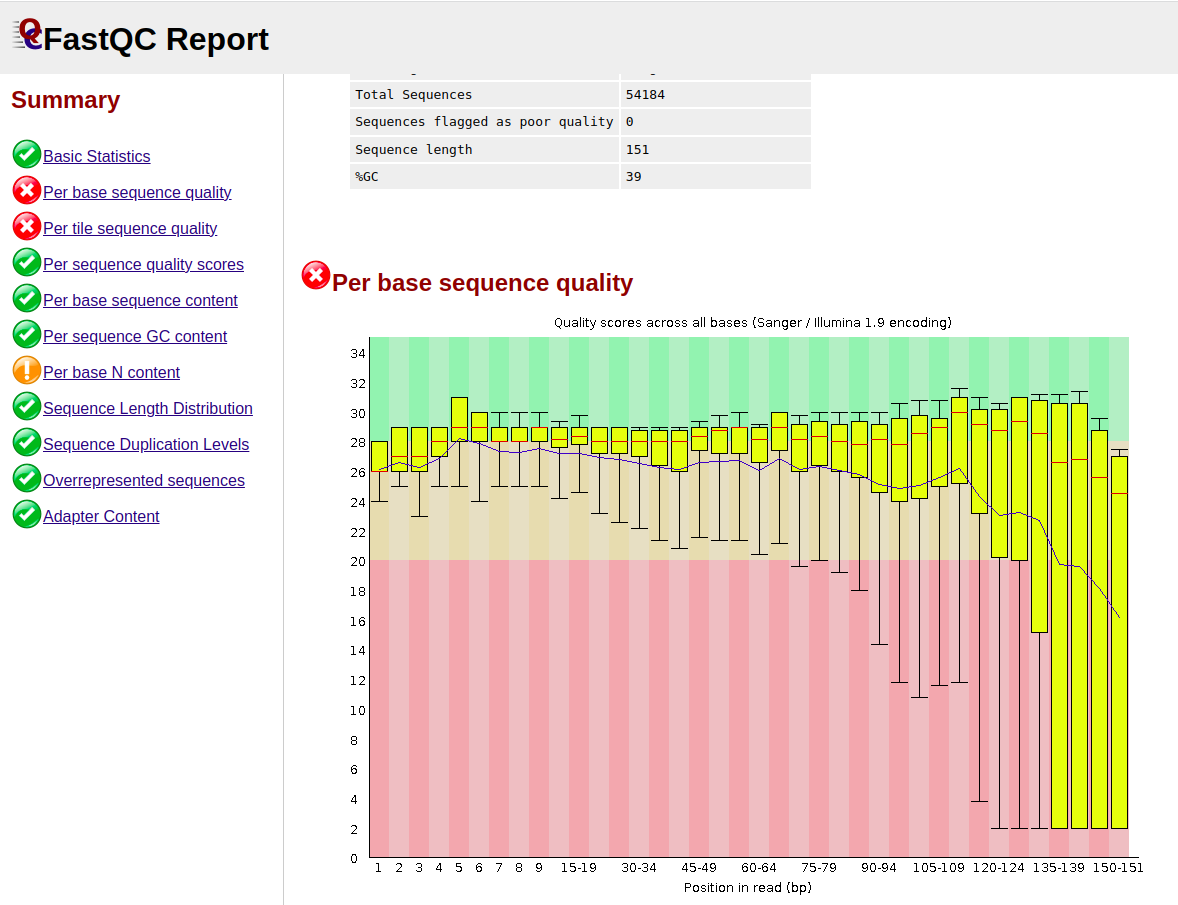

In [7]:
from IPython.display import Image
Image(filename='./fastqc- report .png')

As we can see, FASTQC tool computes many different factors ensuring reliable downstream analysis. On the given data, **read quality seems to drop at the end of sequencing** (red colour means low quality of the read) which is a typical technical issue for Illumina sequencers. **Trimming this low-quality reads is essential** in Illumina NGS sequencing to improve the overall data quality and downstream analysis. Low-quality reads may contain errors, which can lead to inaccurate results. Removing such reads helps increase the reliability of the data, ensuring that subsequent bioinformatics analyses, such as alignment and variant calling, are based on high-quality, trustworthy data, ultimately improving the accuracy and interpretability of the results.

## 3. Pipeline operations

Reads from Illumina seqencers are typically short and do not span over the entire sequence of interest. In order to put the reads together into single strand of read we need to use computational power. We typically use BWA (Burrow's- Wheeler Algorythm which serves to map the sequences (all this little elements) to a reference (which is entire sequenced genome of a man)- just like a puzzle. Here we will use another tool, bwa mem for this:

In [ ]:
# We use -p parameter for paired reads, which regards to the form in which read was obtained 
!bwa mem -p ref/ref.fasta fastq/son.fq > sandbox/son.sam

Next, we need to check how sucessfull mapping was: 

In [ ]:
! samtools flagstat sandbox/son.bam

This is our output:

54306 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
122 + 0 supplementary
0 + 0 duplicates
53994 + 0 mapped (99.43% : N/A)
54184 + 0 paired in sequencing
27092 + 0 read1
27092 + 0 read2
53282 + 0 properly paired (98.34% : N/A)
53560 + 0 with itself and mate mapped
312 + 0 singletons (0.58% : N/A)
0 + 0 with mate mapped to a different chr
0 + 0 with mate mapped to a different chr (mapQ>=5)


99,43 % were correctly mapped to reference. Reads that were not mapped correctly are called **variants**. Variants can be of great importance because some of them carry genetic mutations which cause genetic diseases.   

To further explore variants we need to list them all first in the file of a single format- **VCF**- Variant Call format. For this we will need to use GATK tool which has built-in **Haplotype Caller**. The HaplotypeCaller is a tool in DNA analysis used to identify variations and mutations in DNA sequences. It examines reads from DNA sequencing data and clusters them into haplotypes, which are groups of alleles on a single chromosome. This process helps detect single nucleotide polymorphisms (SNPs) and insertions/deletions (indels), aiding in the identification of genetic variants and their association with specific genomic regions.

In [ ]:
# First three parameters establish reference genome and assembled input sequence and output format 
# - L is also specified- location of researched chromosome. 
! gatk HaplotypeCaller \
    -R ${WORKSPACE}./ref/ref.fasta \
    -I ${WORKSPACE}./bam/son.bam \
    -O ${WORKSPACE}./sandbox/sonHC.vcf \
    -L 20:10,000,000-10,200,000 

Next we will count all the variants using Bash:

In [ ]:
! bcftools view sandbox/sonHC.vcf | grep -v "^#" | wc -l

There are 421 variants. To further investigate VCF format we can check for **multiallelic variants** (mv). MV regards to the situation where more than 2 alleles are present. Typically there are 2 alleles for every gene in human body and presence of more than 2 may in some cases be indicative of the deviation from the norm. For this, we will use another tool, vt:

In [ ]:
# We use -f flag to specify filter condition which is '>= 3 alleles
! vt view -f "N_ALLELE>=3" sandbox/sonHC.vcf | wc -l

There are 6 MV-s. In order to asess if they could be linked with any disease, we would need to check them against a publically available database of variants such as Clinvar, which we will do in the last stage.

To further explore VCF file we can check how many of them are heterogenic and how many are homogenic, using another pipeline tool, called bcftools. 

In [ ]:
# with -i flag we will specify the filtering condition, then we will get rid of VCF headers with -H flag. 
! bcftools view -i 'GT="het"' sandbox/sonHC.vcf | bcftools view -H | wc -l
! bcftools view -i 'GT="hom"' sandbox/sonHC.vcf | bcftools view -H | wc -l

There are 191 heterozygotic and 230 homozygotic variants. Upon researching whether the variant could be harmfull or not, it's zygosicity is an important feature to check; for example some variants are malignant only in one of the forms and completely beningn in other.  

# 4. Data visualisation 



Data visualisation is performed using another tool, **IGV**- *Integrative Genomics Viewer*. It displays all the assembled reads in the tracks, making it possible to look into any part of the sequenced genome. In genomic data processing is important because it could serve several objectives:
1. Genomic Data Exploration: IGV is used to visualize and explore DNA-related data (metadata), such as DNA sequences and gene annotations, enabling researchers to navigate the genome interactively.
2. Structural Variations: IGV helps identify structural variations in DNA, such as insertions, deletions, duplications, translocations, and inversions, providing insights into genetic alterations.
3. Comparing DNA Data: IGV allows for the comparison of DNA-related data across multiple samples or conditions, aiding in identifying similarities and differences in genomic features.


It would make sense if, besides comparing DNA to one reference genome we would also compare it to the seqence genome data of one of the parents. In this example we have the data from the mother: 

In [ ]:
! gsutil cp sandbox/motherHCdebug.ba* gs://bucket-$USER/

Then we would set up IGV tool to work inside a notebook. Before this step it is necessary for the desired file in path to be compressed with gz. In IGV it is also important to use both data and index metadata which ensures correct genome annotation. 

In [ ]:
from igv_jupyterlab import IGV
# At minimum, IGV requires a single argument, genome.
# For supported genomes, a simple name may be supplied.
igv = IGV(genome="hg19" )
display(igv)
import time
time.sleep(3)
t1 = igv.create_track(
name = "son.BAM",
url = "gs://bucket-"+user_name+"/son.bam",
index_url= "gs://bucket-"+user_name+"/son.bam.bai",
showSoftClips=True,
indexed= True
)
t2 = igv.create_track(
name= "son HC VCF",
url= "gs://bucket-"+user_name+"/sonHC.vcf.gz",
index_url= "gs://bucket-"+user_name+"/sonHC.vcf.gz.tbi",
indexed= True,
visibilityWindow= 1000
)
t3 = igv.create_track(
        name= "mother HC debug BAM",
        url= "gs://bucket-"+user_name+"/motherHCdebug.bam",
        index_url= "gs://bucket-"+user_name+"/motherHCdebug.bai",
        indexed= True,
        showSoftClips=True,
        visibilityWindow= 1000
)
igv.load_track(t1)
igv.load_track(t2)
igv.load_track(t3)
igv.search_locus("20", 10002294, 10002623)

...or we could use browser version of the software: https://igv.org/ This is how tracks would look like: 

In [9]:
from IPython.display import Image
image_url = '  HERE '
Image(url = image_url)


# 5. Check if variants are harmfull using variant database


Once we obtained our vcf file, we can check it against a database that decribes variants of clinical importance, such as **ClinVar**. It is important to remember that this is only an example; as genomic data may sometimes be very complex and difficult to interpret in the context of disease, there are many databases categorising variants differently, based on peer- review research.     
Before we can check our variants against Clinvar database, we're going to have to prepare the data by ordering features in vcf file which are important to us.  

In [ ]:
import requests

vcf_file_path = "./sandbox/sonHC.vcf"

# Define a function to parse VCF entries and extract variants
def parse_vcf_file(vcf_file_path):
    variants = []
    with open(vcf_file_path, "r") as vcf_file:
        for line in vcf_file:
            if not line.startswith("#"):
                fields = line.strip().split("\t")
                chromosome = fields[0]
                position = fields[1]
                ref_allele = fields[3]
                alt_allele = fields[4]
                variant = f"{chromosome}:{position}:{ref_allele}:{alt_allele}"
                variants.append(variant)
    return variants

variants = parse_vcf_file(vcf_file_path)

Then we need to access Clinvar API:

In [ ]:
clinvar_api_url = "https://api.ncbi.nlm.nih.gov/clinvar/v2/variation/"

After this, we would need to make API GET request for the server to check every one of the variants for the clinical significance.  

In [ ]:
for variant in variants:
    # Construct the API request URL and sending a GET request
    api_request_url = clinvar_api_url + variant
    response = requests.get(api_request_url)

    if response.status_code == 200:
        # Parsing and processing the response JSON to extract relevant information
        clinvar_data = response.json()
        
        # Extract disease-related information from clinvar_data
        if 'clinical_significance' in clinvar_data:
            clinical_significance = clinvar_data['clinical_significance']
        else:
            clinical_significance = "N/A"
        
        if 'trait_set' in clinvar_data:
            traits = [trait['trait_name'] for trait in clinvar_data['trait_set']]
        else:
            traits = ["N/A"]
        
        # Print or store the relevant data
        print(f"Variant: {variant}")
        print(f"Clinical Significance: {clinical_significance}")
        print(f"Disease Associations: {', '.join(traits)}")
        print("\n")
    else:
        print(f"Failed to retrieve data for variant {variant}")

        
# First, we will specify a file in which we will store the data from server
output_file = "clinvar_data.txt"

# Opening the file for writing
with open(output_file, "w") as file:
    for variant in variants:
        # Constructing the API request URL and sending a GET request
        api_request_url = clinvar_api_url + variant
        response = requests.get(api_request_url)

        if response.status_code == 200:
            # Parsing and processing the response JSON to extract relevant information
            clinvar_data = response.json()
            
            # Extract disease-related information from clinvar_data
            if 'clinical_significance' in clinvar_data:
                clinical_significance = clinvar_data['clinical_significance']
            else:
                clinical_significance = "N/A"
            
            if 'trait_set' in clinvar_data:
                traits = [trait['trait_name'] for trait in clinvar_data['trait_set']]
            else:
                traits = ["N/A"]
            
            # Write the relevant data to the file
            file.write(f"Variant: {variant}\n")
            file.write(f"Clinical Significance: {clinical_significance}\n")
            file.write(f"Disease Associations: {', '.join(traits)}\n\n")
        else:
            print(f"Failed to retrieve data for variant {variant}")


The results can then be utilized in further research involving the patient in collaboration with a geneticist, to determine the familial inheritance pattern of the disease.